# Regularization: in depth

*Fraida Fund*

## Background: regularization

Regularization helps us control the bias-variance tradeoff of a machine learning model by giving us a parameter with which we can tune model “complexity”.

Instead of minimizing the MSE, we define a new loss function that combines the MSE and a penalty function. Then, we minimize this new loss function.

For example, with Ridge regularization, the penalty term is the squared L2 norm of the coefficients, so our new loss function is:

$$J(w) = \|y - X w\|^2_2 + \alpha \|w\|^2_2$$

The complexity parameter $\alpha$ controls the level of regularization: the larger the value of $\alpha$, the more the penalty term “counts”, and the “simpler” the model is.

With LASSO regularization, the penalty term is the L1 norm of the coefficients, so our new loss function is:

$$J(w) = \|y - X w\|^2_2 + \alpha \|w\|_1$$

Again, the complexity parameter $\alpha$ controls the level of regularization: the larger the value of $\alpha$, the more the penalty term “counts”, and the “simpler” the model is.

Another common regularizer is ElasticNet, which combines both L1 and L2 regularization:

$$J(w) \frac{1}{2n} ||X w - y||_2 ^ 2 + \alpha \left( \rho ||w||_1 +
\frac{(1-\rho)}{2} ||w||_2 ^ 2 \right)$$

Here, we control the regularization with two parameters:

-   $\alpha$ controls the overall regularization level. Greater $\alpha$ corresponds to a simpler model
-   $\rho$ is the L1 ratio, and is a value between 0 and 1 that controls the weight of the L1 penalty relative to the L2 penalty. Greater $\rho$ means more L1 regularization and less L2 regularization.

The objective of this notebook is to convince you that both L1 and L2 regularization can reduce the variance of a regression model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# for 3d interactive plots
from ipywidgets import interact, fixed
import ipywidgets as widgets
from mpl_toolkits import mplot3d
from matplotlib import cm


from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler

## Ridge regression (L2 penalty)

With Ridge regularization, the penalty term is the squared L2 norm of the coefficients, so our loss function is:

$$J(w) = \|y - X w\|^2_2 + \alpha \|w\|^2_2$$

(If the data is not zero-mean, the intercept $w_0$ is not included in the penalty term.)

The complexity parameter $\alpha$ controls the level of regularization: the larger the value of $\alpha$, the more the penalty term “counts”, and the “simpler” the model is.

### Collinearity

**Textbook reference on collinearity in linear regression**: For more background reading on this topic, please refer to the discussion on collinearity starting on Page 99 of Introduction to Statistical Learning with Applications in R.

Ridge regression reduces variance for many problems, but it is especially helpful in reducing the variance of models trained on *collinear features*.

You may recall that we saw collinear features before, in our case study on linear regression. There, the individual attractiveness ratings of six “rankers” were highly correlated with one another, as well as with the average attractiveness ranking. We saw that a very large positive coefficient for one variable can be “canceled” by a similarly large negative coefficient on a correlated variable.

To explore this further, we’ll reintroduce a familiar function, our `generate_linear_regression_data` function, with the ability to generate partly collinear features.

In [2]:
def generate_linear_regression_data(n=100, d=1, coef=[5], intercept=1, sigma=0, uninformative=0, collinear=0, collinear_sigma = 0):
  x = np.random.uniform(-1,1,size=(n,d-uninformative-collinear))
  y = (np.dot(x, coef) + intercept).squeeze() + sigma * np.random.randn(n)
  if collinear:
    # select random columns from x
    collinear_cols = np.random.choice(d-uninformative-collinear,size=collinear, replace=True)
    # value of new collinear columns (adds noise so new columns are not exactly collinear)
    collinear_features =  x[:, collinear_cols] + collinear_sigma*np.random.normal(size=(n,collinear))
    x = np.column_stack((x, collinear_features))
  if uninformative:
    x = np.column_stack((x, sigma*np.random.randn(n,uninformative)))

  return x, y

Let’s see how this data generating function works. We will generate some data with five features. The first three features are independent of one another, but the last two features will be highly collinear with a randomly selected column from the first three.

In [3]:
x, y = generate_linear_regression_data(n=50, d=5, coef=[2, 6, 5], collinear=2, collinear_sigma=0.5)

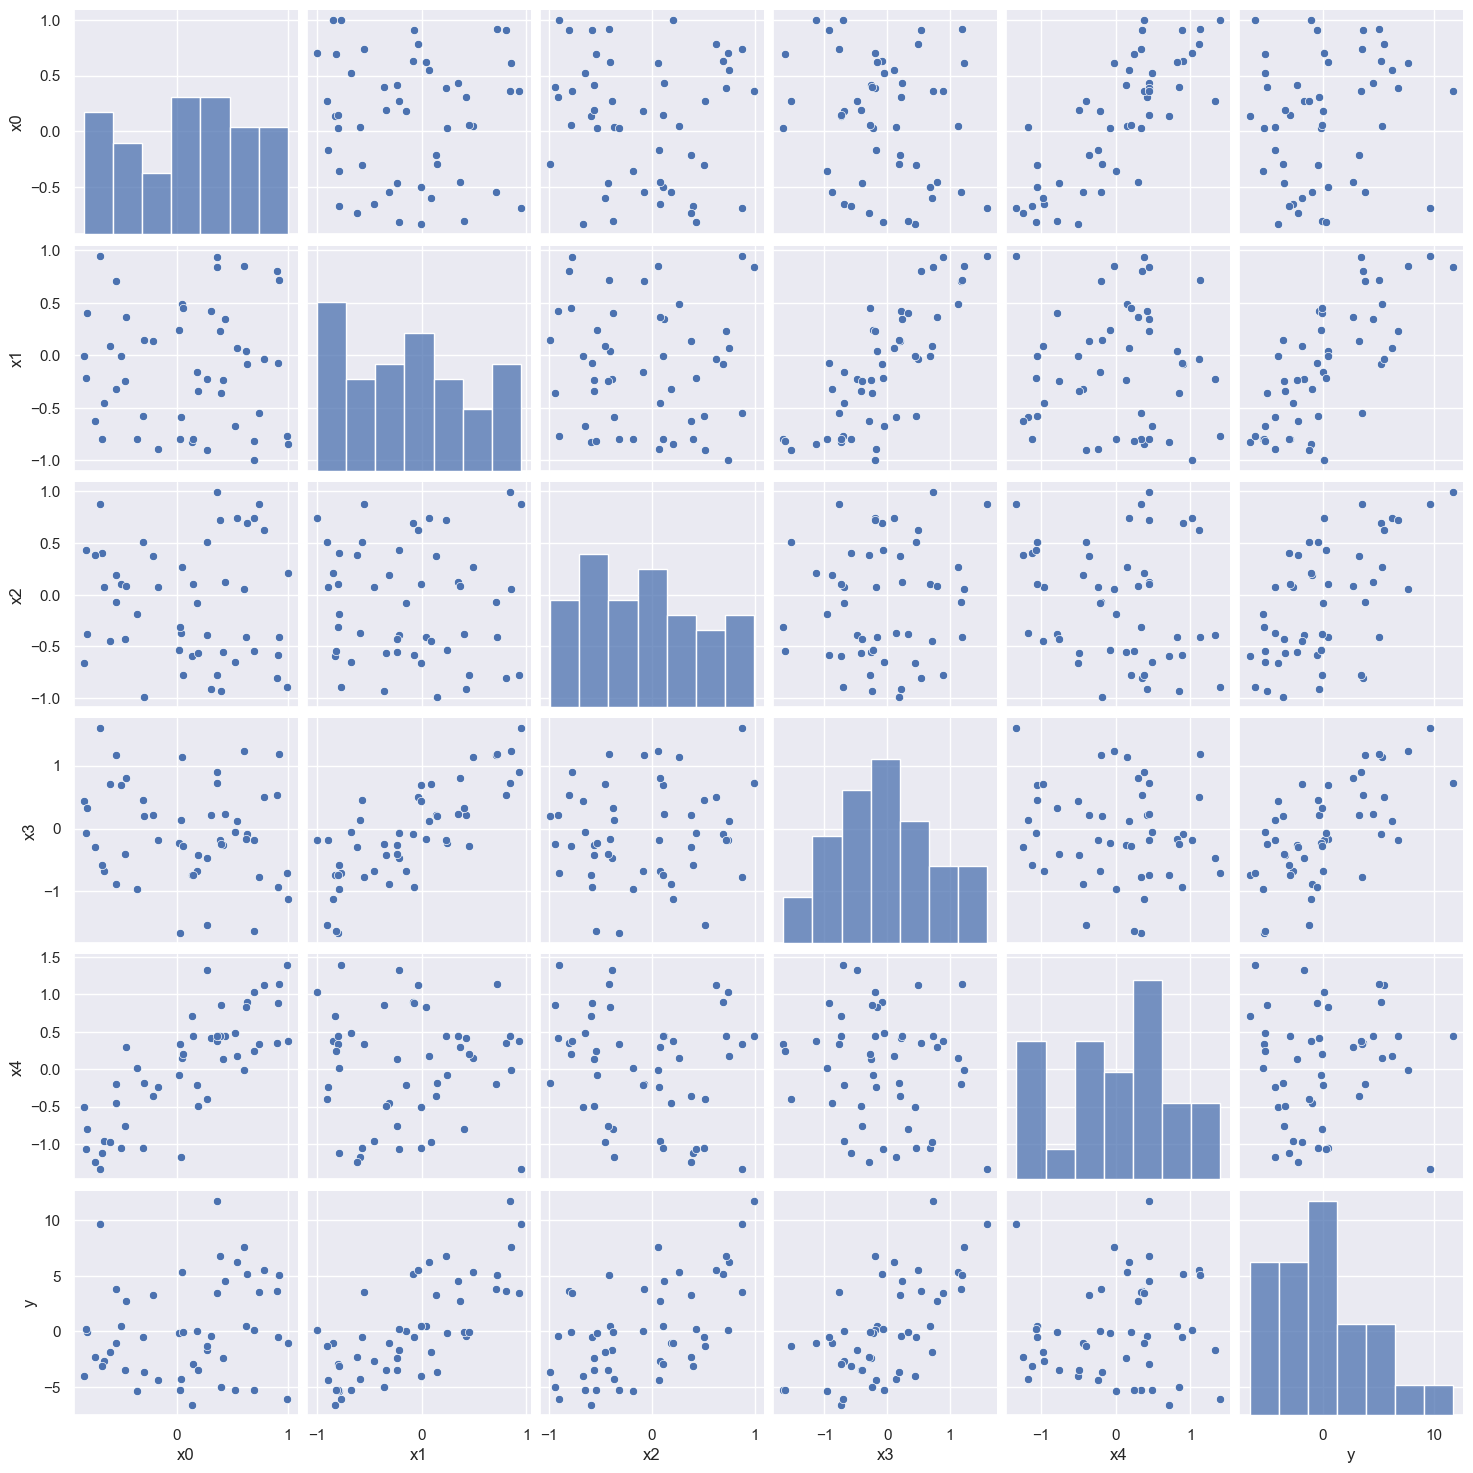

In [4]:
sns.pairplot(pd.DataFrame(np.hstack((x,y.reshape(-1,1))),
                          columns = ['x0', 'x1', 'x2', 'x3', 'x4', 'y']));

We can clearly see the collinearity in the pairplot.

Then, we’ll compute the matrix of correlation coefficients for the five features. An element of this matrix that is large (close to 1) indicates a pair of highly correlated variables.

In [5]:
np.corrcoef(x, rowvar=False)

array([[ 1.        , -0.02479095, -0.08697937, -0.1767405 ,  0.80259926],
       [-0.02479095,  1.        , -0.0494586 ,  0.78671769,  0.01809974],
       [-0.08697937, -0.0494586 ,  1.        ,  0.10226563, -0.18617043],
       [-0.1767405 ,  0.78671769,  0.10226563,  1.        , -0.14167782],
       [ 0.80259926,  0.01809974, -0.18617043, -0.14167782,  1.        ]])

An aside - our function creates new columns that are each a linear function of one other column. In this case, we can see the collinearity by looking at the correlation coefficient, as we have done here.

More generally, a new column may be a linear combination of *multiple* columns. This is known as *multicollinearity* and it wouldn’t necessarily be obvious from the correlation coefficient *or* from the pairplot.

To identify multicollinearity, we should check the Variance Inflation Factor (VIF). A VIF of 1 means no collinearity; a large VIF indicates multicollinearity.

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(x, i) for i in range(x.shape[1])]
vif

[np.float64(2.775773881442464),
 np.float64(2.7970829223610925),
 np.float64(1.074724922922283),
 np.float64(2.893254205308804),
 np.float64(2.8341997771068774)]

### MSE contours with collinearity

Models trained on collinear data have high variance. This is because there can be many *very different* combinations of coefficients that have a similar MSE.

For example, suppose you have a “true” function $f(x_1)$:

$$ y = 2x_1 $$

Now suppose you also have an exactly collinear feature, $x_2 = 4 x_1$.

There are now many coefficients that can exactly predict $y$ using different weights of $x_1$ and $x_2$. We can use:

$$
\begin{aligned}
y &= 2 x_1  \\
y &= \frac{1}{2} x_2  \\
y &= x_1 + \frac{1}{4} x_2
\end{aligned}
$$

etc.

The toy example above has exactly collinear features, but even partly collinear features are problematic, for the same reason. And with partly collinear features, we can’t just disregard one of the features. A partly collinear feature may capture information that isn’t included in any other feature.

### Simulation: collinear features

To further emphasize this point, here is a simulation that compares

-   Model A with one feature that is relevant to the target variable, and another independent feature that is not
-   Model B with one feature that is relevant to the target variable, and another collinear feature

We will generate test data, then generate many independent training sets from the same distribution. For each independent training set, we train each model. In this case, we are especially interested in looking at the coefficient estimates for each model.

In [8]:
n_repeat = 200
n_test = 50
n_train = 50
sigma = 0.5
collinear_sigma = 0.05

# generate test data once
x_test, y_test = generate_linear_regression_data(n=n_test, d=3, coef=[2], intercept=0,
            sigma=sigma, uninformative=1, collinear=1, collinear_sigma=collinear_sigma)
y_test_no_noise =  np.dot(x_test[:,[0]], [2]) + 0

# prepare some matrices for storing simulation results
y_predict = np.zeros((n_test, n_repeat, 2))

y_test_err = np.zeros((n_test, n_repeat, 2))
y_test_bias = np.zeros((n_test, 2))

coefs_sim = np.zeros((2, n_repeat, 2))

# now simulate training the model many times, on different training data every time
# and evaluate using the test data
for i in range(n_repeat):

  # train both models on newly generated training data
  x_train, y_train = generate_linear_regression_data(n=n_train, d=3, coef=[2], intercept=0,
            sigma=sigma, uninformative=1, collinear=1, collinear_sigma=collinear_sigma)

  # model A: use the first (meaningful) column and third (independent, irrelevant) column
  reg_a = LinearRegression(fit_intercept=False).fit([1,5]*x_train[:, [0,2]], y_train)
  y_predict[:, i, 0]  = reg_a.predict([1,5]*x_test[:,[0,2]])
  coefs_sim[:, i, 0]  = reg_a.coef_

  # model B: use the first (meaningful) column and second (collinear) column
  reg_b = LinearRegression(fit_intercept=False).fit([1,5]*x_train[:, [0,1]], y_train)
  y_predict[:, i, 1]  = reg_b.predict([1,5]*x_test[:,[0,1]])
  coefs_sim[:, i, 1]  = reg_b.coef_

  # overall squared error is due to difference between f_t(x) + epsilon, model prediction f(x)
  y_test_err[:, i, 0] = (y_test - y_predict[:, i, 0])**2
  y_test_err[:, i, 1] = (y_test - y_predict[:, i, 1])**2

# bias is due to difference between f_t(x) and mean of model prediction f(x)
y_test_bias[:, 0] = (y_test_no_noise - y_predict[:, :, 0].mean(axis=1))**2
y_test_bias[:, 1] = (y_test_no_noise - y_predict[:, :, 1].mean(axis=1))**2

# irreducible error is due to the difference between f_t(x) and f_t(x) + epsilon
y_test_noise_var = (y_test_no_noise - y_test)**2

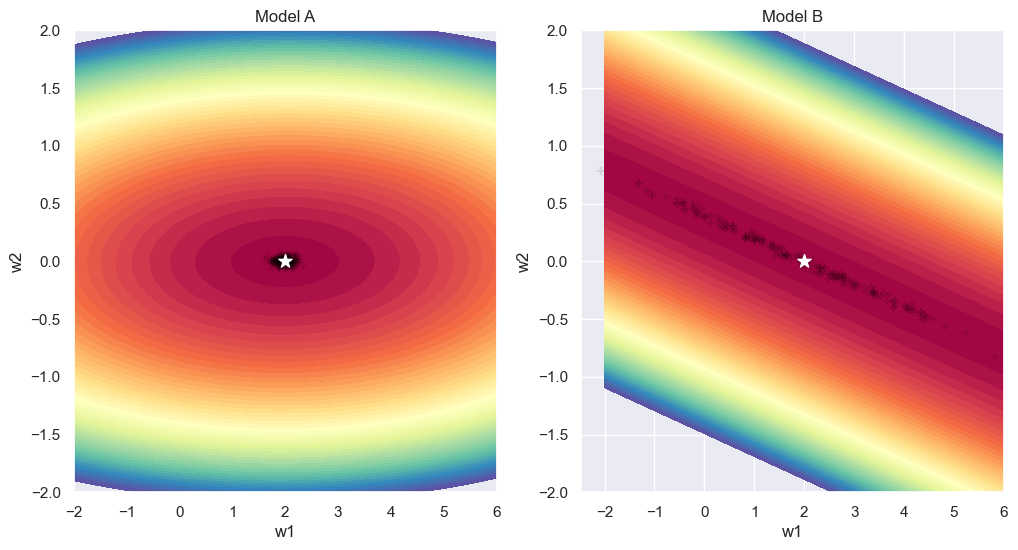

In [9]:

x_mse, y_mse = generate_linear_regression_data(n=1000, d=3, coef=[2], intercept=0,
            sigma=sigma, uninformative=1, collinear=1, collinear_sigma=collinear_sigma)
x_mse_a = [1,5]*x_mse[:, [0,2]]
x_mse_b = [1,5]*x_mse[:, [0,1]]

coefs_1 = np.linspace(-2, 6, 200)
coefs_2 = np.linspace(-2, 2, 200)

coef_grid = np.array(np.meshgrid(coefs_1, coefs_2)).reshape(1, 2, coefs_1.shape[0], coefs_2.shape[0])
y_hat_a = (0 + np.sum(coef_grid * x_mse_a.reshape(x_mse_a.shape[0], 2, 1, 1), axis=1) )
mses_a = np.mean((y_mse.reshape(-1, 1, 1)- y_hat_a)**2,axis=0)
y_hat_b = (0 + np.sum(coef_grid * x_mse_b.reshape(x_mse_b.shape[0], 2, 1, 1), axis=1) )
mses_b = np.mean((y_mse.reshape(-1, 1, 1)- y_hat_b)**2,axis=0)

plt.figure(figsize=(12,6));


plt.subplot(1,2,1)
X1, X2 = np.meshgrid(coefs_1, coefs_2)
p = plt.contourf(X1, X2, mses_a, levels=np.linspace(0, 30, 50), cmap='Spectral');
plt.scatter(coefs_sim[0, :, 0], coefs_sim[1, :, 0], marker='+', color='black', alpha=0.1);
plt.scatter(2, 0, marker='*', color='white', s=100);
plt.xlabel('w1');
plt.ylabel('w2');
plt.title("Model A");

plt.subplot(1,2,2)
X1, X2 = np.meshgrid(coefs_1, coefs_2)
p = plt.contourf(X1, X2, mses_b, levels=np.linspace(0, 30, 50), cmap='Spectral');
plt.scatter(coefs_sim[0, :, 1], coefs_sim[1, :, 1], marker='+', color='black', alpha=0.1);
plt.scatter(2, 0, marker='*', color='white', s=100);
plt.xlabel('w1');
plt.ylabel('w2');
plt.title("Model B");


On both contour plots, the dark red region shows the combination of coefficients where MSE is smallest, and the star marks the “true” coefficients.

-   With two independent features, all of the combinations of coefficients that have small MSE are fairly similar.
-   With collinear features, we can see that the region with small MSE spans a broad range of coefficient values. The region appears as a long, narrow “valley” in the MSE contour. (If you would plot a “higher is better” metric, such as R2, instead of a “lower is better” metric like MSE, you would see a long, narrow “ridge” (Ridge!!!) in the contour plot!)

Looking at the contour plot, we can see how in the model trained on a collinear feature, the coefficient estimates (illustrated as black `+` marks) land in a much larger region.

With collinear features, a small change in the training data could cause the pair of coefficient values that have the smallest MSE - the least squares estimate - to move anywhere along the “valley”. In other words, there is more variance in the coefficient estimates.

### MSE contours with L2 penalty

How does Ridge regularization reduce variance?

When there are collinear features, there are very different coefficient estimates that all have similar MSE. The coefficient estimate is extremely unstable, so the model has high variance.

To reduce the variance, we want to make sure that the training algorithm selects similar coefficients every time, even when there are slight differences in the training data.

What happens when we introduce the L2 penalty term on top of our MSE contours? In the following plot, we show L2 penalty contours for the coefficients overlaid on top of MSE contours.

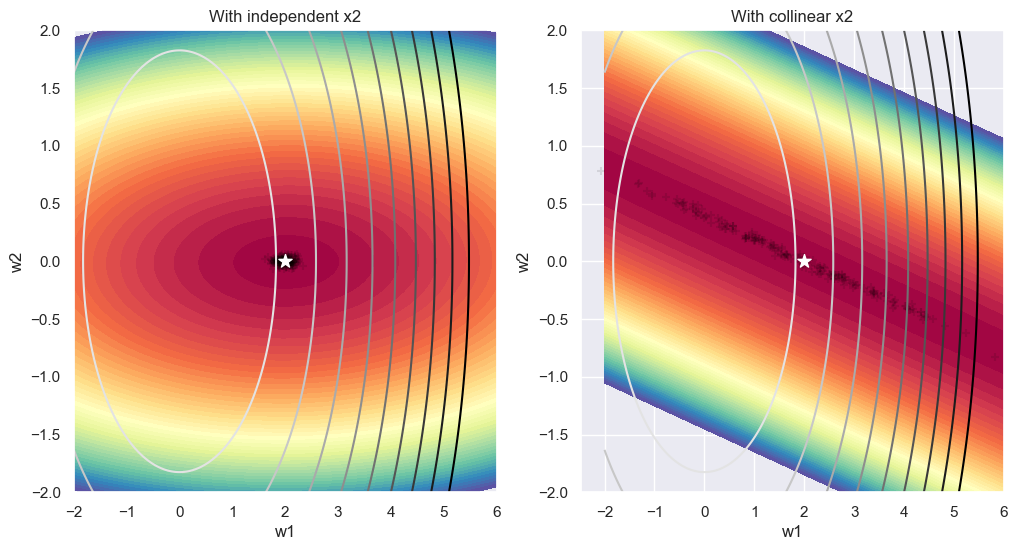

In [10]:
x_mse, y_mse = generate_linear_regression_data(n=1000, d=3, coef=[2], intercept=0,
            sigma=sigma, uninformative=1, collinear=1, collinear_sigma=collinear_sigma)
x_mse_a = [1,5]*x_mse[:, [0,2]]
x_mse_b = [1,5]*x_mse[:, [0,1]]

coefs_1 = np.linspace(-2, 6, 200)
coefs_2 = np.linspace(-2, 2, 200)


coef_grid = np.array(np.meshgrid(coefs_1, coefs_2)).reshape(1, 2, coefs_1.shape[0], coefs_2.shape[0])
y_hat_a = (0 + np.sum(coef_grid * x_mse_a.reshape(x_mse_a.shape[0], 2, 1, 1), axis=1) )
mses_a = np.mean((y_mse.reshape(-1, 1, 1)- y_hat_a)**2,axis=0)
y_hat_b = (0 + np.sum(coef_grid * x_mse_b.reshape(x_mse_b.shape[0], 2, 1, 1), axis=1) )
mses_b = np.mean((y_mse.reshape(-1, 1, 1)- y_hat_b)**2,axis=0)

l2_penalty_coefs = np.linalg.norm(coef_grid, ord=2, axis=1).squeeze()**2
plt.figure(figsize=(12,6));

plt.subplot(1,2,1)
X1, X2 = np.meshgrid(coefs_1, coefs_2)
p = plt.contourf(X1, X2, mses_a, levels=np.linspace(0, 30, 50), cmap='Spectral');
p = plt.contour(X1, X2, l2_penalty_coefs, levels=np.linspace(0, 30, 10), cmap='binary');
plt.scatter(coefs_sim[0, :, 0], coefs_sim[1, :, 0], marker='+', color='black', alpha=0.1);
plt.scatter(2, 0, marker='*', color='white', s=100);
plt.xlabel('w1');
plt.ylabel('w2');
plt.title("With independent x2");

plt.subplot(1,2,2)
X1, X2 = np.meshgrid(coefs_1, coefs_2)
p = plt.contourf(X1, X2, mses_b, levels=np.linspace(0, 30, 50), cmap='Spectral');
p = plt.contour(X1, X2, l2_penalty_coefs, levels=np.linspace(0, 30, 10), cmap='binary');
plt.scatter(coefs_sim[0, :, 1], coefs_sim[1, :, 1], marker='+', color='black', alpha=0.1);
plt.scatter(2, 0, marker='*', color='white', s=100);
plt.xlabel('w1');
plt.ylabel('w2');
plt.title("With collinear x2");

The MSE term in the loss function tends to push our coefficient estimates towards the “true” coefficients, in the center of the dark red region. At the same time, the L2 penalty term tends to push our coefficient estimate towards the origin, in the center of the white oval region. The $\alpha$ parameter determines the relative strength of each effect.

When we used MSE alone as our loss function, there was a wide range of coefficients with almost equivalent MSE. Now, with the addition of the L2 penalty, there is a much smaller range of coefficients with small MSE *and* small L2 penalty.

We can see this more clearly if we plot the contour of the Ridge loss function

$$J(w) = \|y - X w\|^2_2 + \alpha \|w\|^2_2$$

with $\alpha=0.5$, instead of the MSE contour.

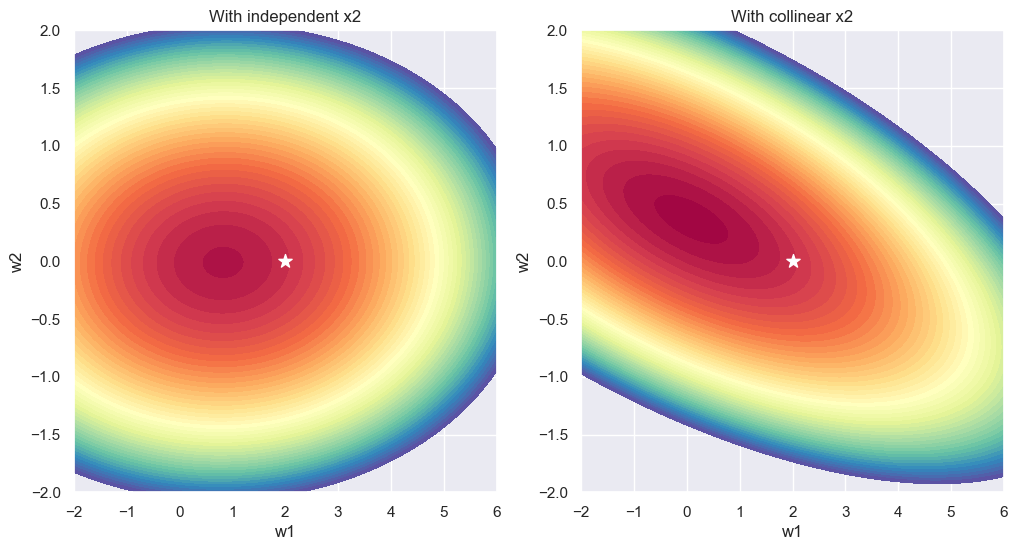

In [11]:
alpha = 0.5
plt.figure(figsize=(12,6));

plt.subplot(1,2,1)
X1, X2 = np.meshgrid(coefs_1, coefs_2)
p = plt.contourf(X1, X2, mses_a + alpha*l2_penalty_coefs, levels=np.linspace(0, 30, 50), cmap='Spectral');
plt.scatter(2, 0, marker='*', color='white', s=100);
plt.xlabel('w1');
plt.ylabel('w2');
plt.title("With independent x2");

plt.subplot(1,2,2)
X1, X2 = np.meshgrid(coefs_1, coefs_2)
p = plt.contourf(X1, X2, mses_b + alpha*l2_penalty_coefs, levels=np.linspace(0, 30, 50), cmap='Spectral');
plt.scatter(2, 0, marker='*', color='white', s=100);
plt.xlabel('w1');
plt.ylabel('w2');
plt.title("With collinear x2");

For both loss surfaces, the regularized loss function shrinks the region of coefficients for which the loss function is very small - the region of likely coefficient estimates.

In the case with collinear features, though, the *range* of coefficient values with small loss shrinks dramatically due to regularization. The L2 penalty term “pulls up” on the parts of the “ridge” that are far from the origin, increasing the value of the loss function there. The long, narrow “ridge” becomes a small peak, and the coefficient estimates are now much more stable.

However, the “true” coefficients (illustrated with a white star) may no longer be included in the region where the value of the loss function is smallest - the L2 penalty introduces *bias*, moving the coefficient estimate away from the true value.

We can see this more clearly by repeating the simulation above, but with Ridge regression instead of the unregularized regression.

### Simulation: L2 penalty

We can also see the effect of the L2 penalty in simulation. Here, we compare:

-   Model A with one feature that is relevant to the target variable, and another independent feature that is not
-   Model B with one feature that is relevant to the target variable, and another collinear feature

both trained using Ridge regression with $\alpha=0.1$.

Note that we can fit a Ridge regression in `sklearn` using our standard “recipe”, with the addition of the `alpha` parameter. The general usage is

``` python
m = Ridge(alpha=0.1)    # create an instance of a Ridge, specify alpha
m.fit(x_tr, y_tr)       # fit the model using the training data. Note: x_tr must be 2D
...                     # the rest is exactly the same as with a LinearRegression model
```

In [12]:
n_repeat = 200
n_test = 50
n_train = 50
sigma = 0.5
collinear_sigma = 0.05
alpha = 0.1

# generate test data once
x_test, y_test = generate_linear_regression_data(n=n_test, d=3, coef=[2], intercept=0,
            sigma=sigma, uninformative=1, collinear=1, collinear_sigma=collinear_sigma)
y_test_no_noise =  np.dot(x_test[:,[0]], [2]) + 0

# prepare some matrices for storing simulation results
y_predict = np.zeros((n_test, n_repeat, 2))

y_test_err = np.zeros((n_test, n_repeat, 2))
y_test_bias = np.zeros((n_test, 2))

coefs_sim = np.zeros((2, n_repeat, 2))

# now simulate training the model many times, on different training data every time
# and evaluate using the test data
for i in range(n_repeat):

  # train both models on newly generated training data
  x_train, y_train = generate_linear_regression_data(n=n_train, d=3, coef=[2], intercept=0,
            sigma=sigma, uninformative=1, collinear=1, collinear_sigma=collinear_sigma)

  # model A: use the first (meaningful) column and third (independent, irrelevant) column
  reg_a = Ridge(alpha=alpha, fit_intercept=False).fit([1,5]*x_train[:, [0,2]], y_train)
  y_predict[:, i, 0]  = reg_a.predict([1,5]*x_test[:,[0,2]])
  coefs_sim[:, i, 0]  = reg_a.coef_

  # model B: use the first (meaningful) column and second (collinear) column
  reg_b = Ridge(alpha=alpha, fit_intercept=False).fit([1,5]*x_train[:, [0,1]], y_train)
  y_predict[:, i, 1]  = reg_b.predict([1,5]*x_test[:,[0,1]])
  coefs_sim[:, i, 1]  = reg_b.coef_

  # overall squared error is due to difference between f_t(x) + epsilon, model prediction f(x)
  y_test_err[:, i, 0] = (y_test - y_predict[:, i, 0])**2
  y_test_err[:, i, 1] = (y_test - y_predict[:, i, 1])**2

# bias is due to difference between f_t(x) and mean of model prediction f(x)
y_test_bias[:, 0] = (y_test_no_noise - y_predict[:, :, 0].mean(axis=1))**2
y_test_bias[:, 1] = (y_test_no_noise - y_predict[:, :, 1].mean(axis=1))**2

# irreducible error is due to the difference between f_t(x) and f_t(x) + epsilon
y_test_noise_var = (y_test_no_noise - y_test)**2

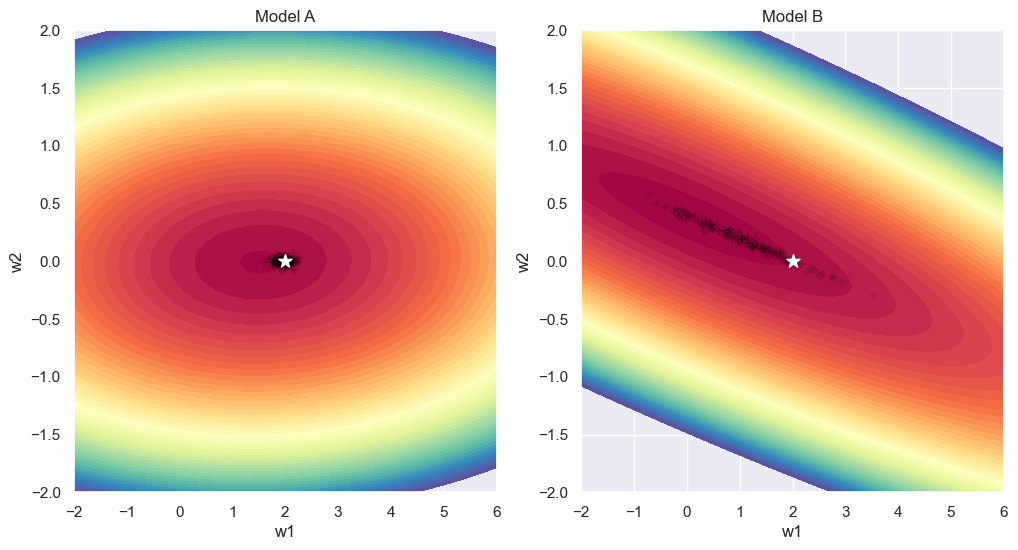

In [13]:
x_mse, y_mse = generate_linear_regression_data(n=1000, d=3, coef=[2], intercept=0,
            sigma=sigma, uninformative=1, collinear=1, collinear_sigma=collinear_sigma)
x_mse_a = [1,5]*x_mse[:, [0,2]]
x_mse_b = [1,5]*x_mse[:, [0,1]]

coefs_1 = np.linspace(-2, 6, 200)
coefs_2 = np.linspace(-2, 2, 200)

coef_grid = np.array(np.meshgrid(coefs_1, coefs_2)).reshape(1, 2, coefs_1.shape[0], coefs_2.shape[0])


y_hat_a = (0 + np.sum(coef_grid * x_mse_a.reshape(x_mse_a.shape[0], 2, 1, 1), axis=1) )
mses_a = np.mean((y_mse.reshape(-1, 1, 1)- y_hat_a)**2,axis=0)
y_hat_b = (0 + np.sum(coef_grid * x_mse_b.reshape(x_mse_b.shape[0], 2, 1, 1), axis=1) )
mses_b = np.mean((y_mse.reshape(-1, 1, 1)- y_hat_b)**2,axis=0)

x_cost_a = mses_a + alpha*np.linalg.norm(coef_grid, ord=2, axis=1).squeeze()**2
x_cost_b = mses_b + alpha*np.linalg.norm(coef_grid, ord=2, axis=1).squeeze()**2

plt.figure(figsize=(12,6));


plt.subplot(1,2,1)
X1, X2 = np.meshgrid(coefs_1, coefs_2)
p = plt.contourf(X1, X2, x_cost_a, levels=np.linspace(0, 30, 50), cmap='Spectral');
plt.scatter(coefs_sim[0, :, 0], coefs_sim[1, :, 0], marker='+', color='black', alpha=0.1);
plt.scatter(2, 0, marker='*', color='white', s=100);
plt.xlabel('w1');
plt.ylabel('w2');
plt.title("Model A");

plt.subplot(1,2,2)
X1, X2 = np.meshgrid(coefs_1, coefs_2)
p = plt.contourf(X1, X2, x_cost_b, levels=np.linspace(0, 30, 50), cmap='Spectral');
plt.scatter(coefs_sim[0, :, 1], coefs_sim[1, :, 1], marker='+', color='black', alpha=0.1);
plt.scatter(2, 0, marker='*', color='white', s=100);
plt.xlabel('w1');
plt.ylabel('w2');
plt.title("Model B");

Note that the dark red contour in the regularized cost function is much smaller than in the non-regularized version above, especially for the model trained with a collinear feature!

The parameter estimates are concentrated in this smaller area. However, note that the average of all those estimates is no longer the same as the true coefficient value. (A regularized model is *not* unbiased!)

Let’s make the comparison more explicit. In the next simulation, we’ll compare two models trained on the same data:

-   Model A, which is a least squares linear regression trained on two collinear features.
-   Model B, which is a linear regression with an L2 penalty, also trained on two collinear features.

and we will also look at the bias and variance of each model.

In [14]:
n_repeat = 1000
n_test = 50
n_train = 50
sigma = 0.5
alpha = 0.5

# generate test data once
x_test, y_test = generate_linear_regression_data(n=n_test, d=2, coef=[2], intercept=0, sigma=sigma, collinear=1, collinear_sigma=0.1)
x_test = [1,5]*x_test
y_test_no_noise =  np.dot(x_test[:,[0]], [2]) + 0

# prepare some matrices for storing simulation results
y_predict = np.zeros((n_test, n_repeat, 2))

y_test_err = np.zeros((n_test, n_repeat, 2))
y_test_bias = np.zeros((n_test, 2))

coefs_sim = np.zeros((2, n_repeat, 2))

# now simulate training the model many times, on different training data every time
# and evaluate using the test data
for i in range(n_repeat):

  # train both models on newly generated training data
  x_train, y_train = generate_linear_regression_data(n=n_train, d=2, coef=[2], sigma=sigma, collinear=1, collinear_sigma=0.1)
  x_train = [1,5]*x_train

  # model A: use linear regression
  reg_a = LinearRegression(fit_intercept=False).fit(x_train, y_train)
  y_predict[:, i, 0]  = reg_a.predict(x_test)
  coefs_sim[:, i, 0]  = reg_a.coef_

  # model B: use ridge regression
  reg_b = Ridge(fit_intercept=False, alpha=alpha).fit(x_train, y_train)
  y_predict[:, i, 1]  = reg_b.predict(x_test)
  coefs_sim[:, i, 1]  = reg_b.coef_

  # overall squared error is due to difference between f_t(x) + epsilon, model prediction f(x)
  y_test_err[:, i, 0] = (y_test - y_predict[:, i, 0])**2
  y_test_err[:, i, 1] = (y_test - y_predict[:, i, 1])**2

# bias is due to difference between f_t(x) and mean of model prediction f(x)
y_test_bias[:, 0] = (y_test_no_noise - y_predict[:, :, 0].mean(axis=1))**2
y_test_bias[:, 1] = (y_test_no_noise - y_predict[:, :, 1].mean(axis=1))**2

# irreducible error is due to the difference between f_t(x) and f_t(x) + epsilon
y_test_noise_var = (y_test_no_noise - y_test)**2


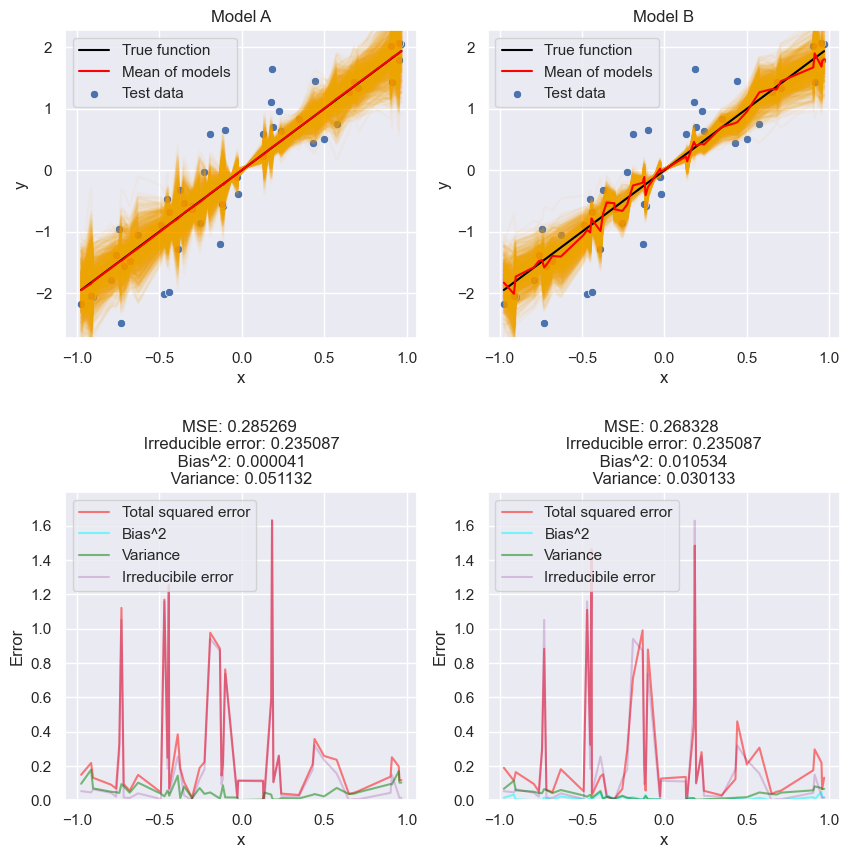

In [15]:
p = plt.figure(figsize=(10,10));

models = ['Model A', 'Model B']

for midx, model in enumerate(models):
  p = plt.subplot(2, 2, midx+1);
  for i in range(n_repeat):
    p = sns.lineplot(x=x_test[:,0], y=y_predict[:, i, midx], alpha=0.05, color='orange');
  p = sns.lineplot(x=x_test[:,0], y=y_test_no_noise, color='black', label='True function');
  p = sns.lineplot(x=x_test[:,0], y=y_predict[:, :, midx].mean(axis=1), color='red', label='Mean of models');
  p = sns.scatterplot(x=x_test[:,0], y=y_test, label='Test data');
  p = plt.xlabel('x');
  p = plt.ylabel('y');
  p = plt.title(model);
  p = plt.ylim(y_test.min()*1.1, y_test.max()*1.1)

  p = plt.subplot(2, 2, midx+3);
  p = sns.lineplot(x=x_test[:,0], y=y_test_err[:, :, midx].mean(axis=1), color='red', alpha=0.5, label='Total squared error', markers=True);
  p = sns.lineplot(x=x_test[:,0], y=y_test_bias[:, midx], color='cyan', alpha=0.5, label='Bias^2');
  p = sns.lineplot(x=x_test[:,0], y=y_predict[:, :, midx].var(axis=1), color='green', alpha=0.5, label='Variance');
  p = sns.lineplot(x=x_test[:,0], y=y_test_noise_var, color='purple', alpha=0.2, label='Irreducibile error');
  p = plt.xlabel('x');
  p = plt.ylabel('Error');
  p = plt.title("MSE: %f \n Irreducible error: %f \n Bias^2: %f \n Variance: %f " %
                (y_test_err[:,:,midx].mean(axis=(0,1)),
                 y_test_noise_var.mean(),
                 (y_test_bias[:, midx]).mean(),
                  y_predict[:, :, midx].var(axis=1).mean() ) )
  p = plt.ylim(0, 1.1* y_test_err[:, :, :].mean(axis=(1)).max() )

plt.subplots_adjust(hspace=0.5)

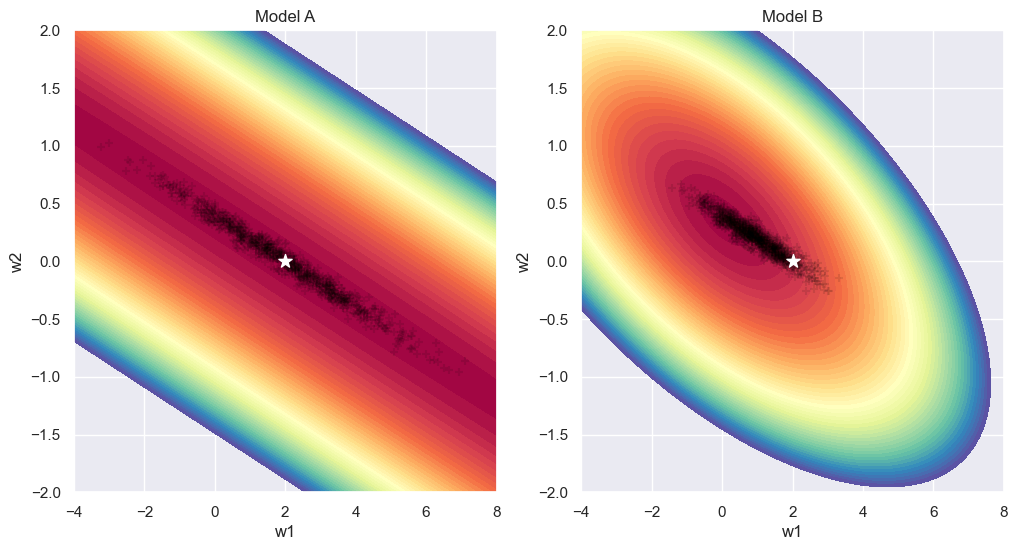

In [16]:
x_mse, y_mse = generate_linear_regression_data(n=1000, d=2, coef=[2], intercept=0,
            sigma=sigma, collinear=1, collinear_sigma=collinear_sigma)
x_mse = [1,5]*x_mse

coefs_1 = np.linspace(-4, 8, 200)
coefs_2 = np.linspace(-2, 2, 200)

coef_grid = np.array(np.meshgrid(coefs_1, coefs_2)).reshape(1, 2, coefs_1.shape[0], coefs_2.shape[0])


y_hat = (0 + np.sum(coef_grid * x_mse.reshape(x_mse.shape[0], 2, 1, 1), axis=1) )
mses = np.mean((y_mse.reshape(-1, 1, 1)- y_hat)**2,axis=0)

x_cost_a = mses
x_cost_b = mses + alpha*np.linalg.norm(coef_grid, ord=2, axis=1).squeeze()**2

plt.figure(figsize=(12,6));


plt.subplot(1,2,1)
X1, X2 = np.meshgrid(coefs_1, coefs_2)
p = plt.contourf(X1, X2, x_cost_a, levels=np.linspace(0, 30, 50), cmap='Spectral');
plt.scatter(coefs_sim[0, :, 0], coefs_sim[1, :, 0], marker='+', color='black', alpha=0.1);
plt.scatter(2, 0, marker='*', color='white', s=100);
plt.xlabel('w1');
plt.ylabel('w2');
plt.title("Model A");

plt.subplot(1,2,2)
X1, X2 = np.meshgrid(coefs_1, coefs_2)
p = plt.contourf(X1, X2, x_cost_b, levels=np.linspace(0, 30, 50), cmap='Spectral');
plt.scatter(coefs_sim[0, :, 1], coefs_sim[1, :, 1], marker='+', color='black', alpha=0.1);
plt.scatter(2, 0, marker='*', color='white', s=100);
plt.xlabel('w1');
plt.ylabel('w2');
plt.title("Model B");

Model B, which uses an L2 penalty term in the loss function, has much lower variance than Model A.

However, Model B also has higher bias.

While there is some estimation error in individual coefficient estimates of a least squares linear regression, it will estimate the “true” coefficients *on average*, so as long as there is no under-modeling, it will be unbiased. We can see that the mean prediction for this test set (red line) is almost exactly the same as the true function (black line) in the top left plot.

The Ridge regression, on the other hand, does *not* estimate the “true” coefficient on average, since the L2 penalty term pushes it to estimate coefficients with slightly smaller magnitude than the true values. Therefore, its estimate is biased even if there is no under-modeling. We can see that the mean prediction for this test set (red line) is *not* the same as the true function (black line) in the top right plot. The mean prediction has a coefficient with a slightly smaller magnitude.

As $\alpha$ increases the weight of the L2 penalty term, the variance of the model decreases, but the bias increases. The optimal $\alpha$ for a given problem will depend on whether bias outweighs variance in the MSE breakdown. In a model with high bias, regularization will make the overall MSE worse. In a model with high variance, regularization will increase bias but will still improve MSE.

How should we choose $\alpha$, if it increases bias but decreases variance? The choice of $\alpha$ is essentially a model selection problem. We can use cross validation to select the $\alpha$ for which the validation MSE is the lowest.

### Standardizing inputs

One important thing to be aware of: the L2 penalty term disproportionately “shrinks” large coefficients compared to small coefficients.

You can think of the L2 penalty as a rubber band connecting each coefficient value and the origin. The rubber band “pulls” the coefficient towards the origin, but it pull more strongly on large coefficients, for which the rubber band is stretched more tightly.

This can be especially problematic when we have features with different scales, which in turn leads to coefficients on different scales. In least squares linear regression, scaling any variable wouldn’t affect the MSE. In Ridge regression, scaling a variable changes the way that the L2 penalty acts on its coefficient.

To prevent this, and make sure Ridge penalizes all coefficients “fairly”, we will usually “standardize” inputs before applying Ridge regression.

To explore this further, we will generate linear data in which two features $x_1$ and $x_2$ are equally important for determining $y$, but the scale is different by a factor of 10, so the coefficients are also different by a factor of 10.

In [17]:
x_a, y_a = generate_linear_regression_data(n=500, d=1, coef=[2])
x_b, y_b = generate_linear_regression_data(n=500, d=1, coef=[2])
x_b_scaled = x_b*10

coefs = [2, 2/10.0]
intercept=2

y = y_a + y_b
x = np.hstack((x_a, x_b_scaled))

To see what happens to the coefficients as we apply Ridge regression with increasing $\alpha$, we are going to create a plot of the “regularization path”. This plot shows how the values of the coefficients change as the weight of the regularization penalty in the loss function changes.

In [18]:
alpha_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
coefs_alpha = np.zeros((len(alpha_list), 2))

for idx, alpha in enumerate(alpha_list):
    regr_ridge = Ridge(alpha=alpha).fit(x,y)
    coefs_alpha[idx] = regr_ridge.coef_

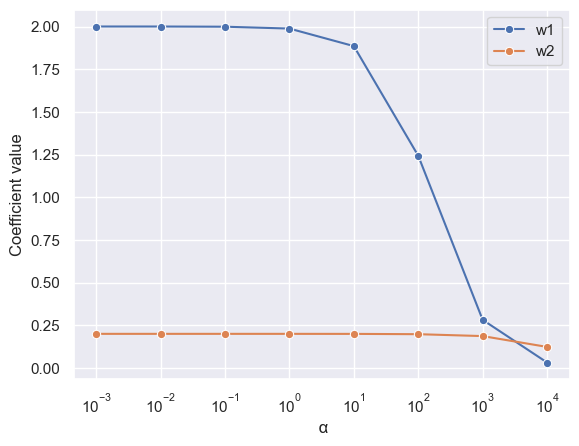

In [19]:
sns.lineplot(x=alpha_list, y=coefs_alpha[:, 0], label='w1', marker='o');
sns.lineplot(x=alpha_list, y=coefs_alpha[:, 1], label='w2', marker='o');
plt.xscale('log')
plt.ylabel("Coefficient value");
plt.xlabel(" α");

To reduce the L2 penalty, it is much more effective to reduce large coefficients than small coefficients. The larger coefficient is therefore “pulled” much more strongly to zero.

To address this (and for other reasons beyond the scope of this course), we typically scale or standardize our data before applying Ridge regression. The most common approach is to *standardize* - for each sample, we compute

$$x_{i,d}' = (x_{i,d} - \bar{x}_d) / \sigma_{x_d}$$

for each sample $i$ and feature $d$, where $\bar{x}_d$ is the mean of the training samples for feature $d$ and $\sigma_{x_d}$ is the standard deviation of the training samples for feature $d$.

The `sklearn` library includes a `StandardScaler` that can be used for this purpose.

In [20]:
scaler = StandardScaler().fit(x)
x_scaled = scaler.transform(x)

In [21]:
alpha_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
coefs_alpha = np.zeros((len(alpha_list), 2))

for idx, alpha in enumerate(alpha_list):
    regr_ridge = Ridge(alpha=alpha).fit(x_scaled,y)
    coefs_alpha[idx] = regr_ridge.coef_

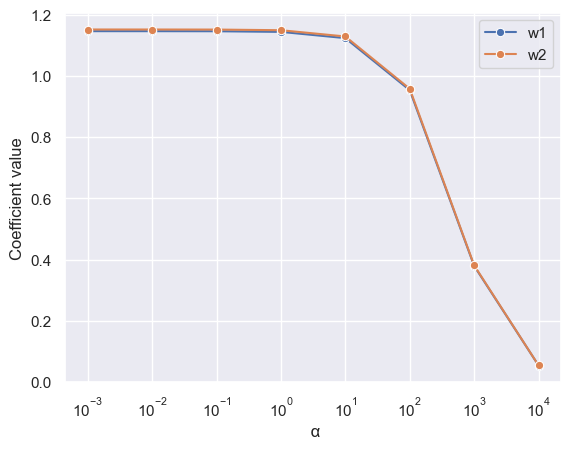

In [22]:
sns.lineplot(x=alpha_list, y=coefs_alpha[:, 0], label='w1', marker='o');
sns.lineplot(x=alpha_list, y=coefs_alpha[:, 1], label='w2', marker='o');
plt.xscale('log')
plt.ylabel("Coefficient value");
plt.xlabel(" α");

Now we can see that the Ridge regularizer exerts the same “pull” on both coefficients.

Important note: When you use a `StandardScaler` to transform your training data before fitting your model, you must use the same `StandardScaler` object to transform your test data before using your fitted model for predictions!

Don’t fit the `StandardScaler` again, just use the scaler that was *already fitted using your training data* on your test data, like

    x_test_scaled = scaler.transform(x_test)

## LASSO regression (L1 penalty)

With LASSO regularization, the penalty term is the L1 norm of the coefficients, so our loss function is:

$$J(w) = \|y - X w\|^2_2 + \alpha \|w\|_1$$

(If the data is not zero-mean, the intercept $w_0$ is not included in the penalty term.)

The complexity parameter $\alpha$ controls the level of regularization: the larger the value of $\alpha$, the more the penalty term “counts”, and the “simpler” the model is.

### Feature selection

LASSO regression reduces variance in general, but it is especially helpful as an automated feature selection method.

In a previous notebook, we saw that a model trained on a large number of features - especially so-called “uninformative” features - has very high variance. Ideally, we would want to use only the most informative features to train our model, and exclude the less informative features. This model selection problem is known as feature selection.

LASSO “zeros out” some coefficients, so the features associated with them are not used for prediction. It is essentially an automated feature selection method.

### Simulation: uninformative features

Let us remind ourselves of the effect of uninformative features, using a simulation. Here, we compare:

-   Model A, which is a least squares linear regression trained on one informative feature.

$$t(x) = w_{0,t} + w_{1,t} x_1, \quad f(x,w) = w_{0} + w_{1} x_1$$

-   Model B, which is a least squares linear regression trained on one informative feature and five uninformative features.

$$t(x) = w_{0,t} + w_{1,t} x_1, \quad  f(x,w) = w_{0} + w_{1} x_1 + w_2 x_2 + w_3 x_3 + w_4 x_4 + w_5 x_5 + w_6 x_6$$

In [23]:
n_repeat = 1000
n_test = 50
n_train = 50
sigma = 1


# generate test data once
x_test, y_test = generate_linear_regression_data(n=n_test, d=6, coef=[2], intercept=1, sigma=sigma, uninformative=5)
y_test_no_noise =  np.dot(x_test[:,0:1], [2]) + 1


# prepare some matrices for storing simulation results
y_predict = np.zeros((n_test, n_repeat, 2))

y_test_err = np.zeros((n_test, n_repeat, 2))
y_test_bias = np.zeros((n_test, 2))

# now simulate training the model many times, on different training data every time
# and evaluate using the test data
for i in range(n_repeat):

  # train both models on newly generated training data
  x_train, y_train = generate_linear_regression_data(n=n_test, d=6, coef=[2], intercept=1, sigma=sigma, uninformative=5)

  # model A: use only the first column
  y_predict[:, i, 0] = LinearRegression().fit(x_train[:, 0:1], y_train).predict(x_test[:,0:1])
  # model B: use all columns
  y_predict[:, i, 1] = LinearRegression().fit(x_train, y_train).predict(x_test)

  # overall squared error is due to difference between f_t(x) + epsilon, model prediction f(x)
  y_test_err[:, i, 0] = (y_test - y_predict[:, i, 0])**2
  y_test_err[:, i, 1] = (y_test - y_predict[:, i, 1])**2

# bias is due to difference between f_t(x) and mean of model prediction f(x)
y_test_bias[:, 0] = (y_test_no_noise - y_predict[:, :, 0].mean(axis=1))**2
y_test_bias[:, 1] = (y_test_no_noise - y_predict[:, :, 1].mean(axis=1))**2

# irreducible error is due to the difference between f_t(x) and f_t(x) + epsilon
y_test_noise_var = (y_test_no_noise - y_test)**2

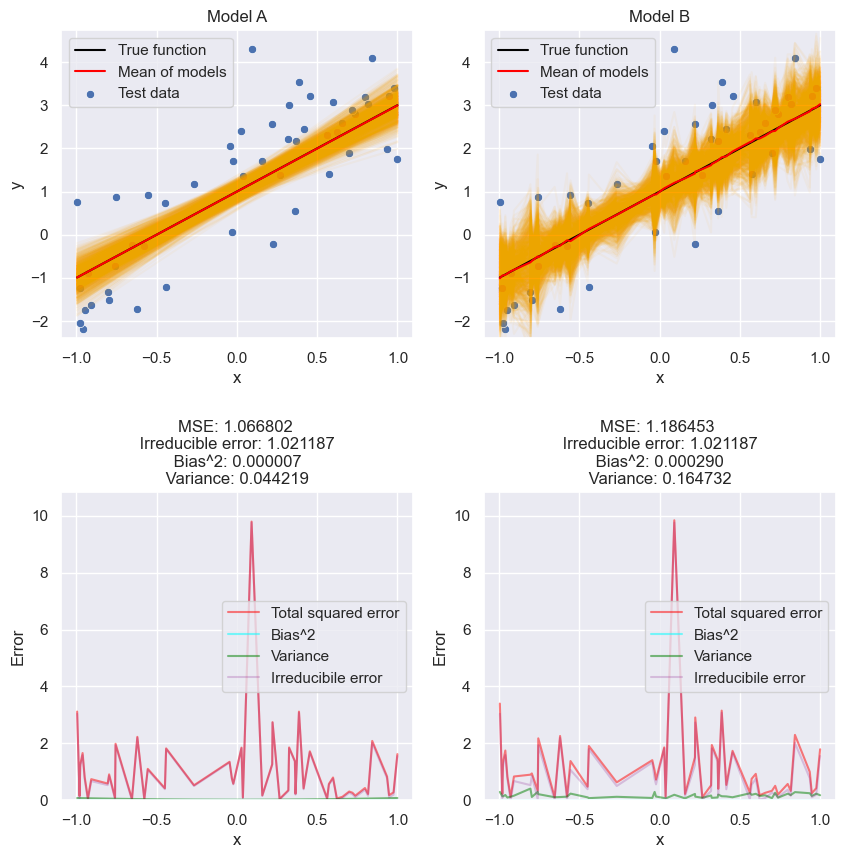

In [24]:
p = plt.figure(figsize=(10,10));

models = ['Model A', 'Model B']

for midx, model in enumerate(models):
  p = plt.subplot(2, 2, midx+1);
  for i in range(n_repeat):
    p = sns.lineplot(x=x_test[:,0], y=y_predict[:, i, midx], alpha=0.05, color='orange');
  p = sns.lineplot(x=x_test[:,0], y=y_test_no_noise, color='black', label='True function');
  p = sns.lineplot(x=x_test[:,0], y=y_predict[:, :, midx].mean(axis=1), color='red', label='Mean of models');
  p = sns.scatterplot(x=x_test[:,0], y=y_test, label='Test data');
  p = plt.xlabel('x');
  p = plt.ylabel('y');
  p = plt.title(model);
  p = plt.ylim(y_test.min()*1.1, y_test.max()*1.1)

  p = plt.subplot(2, 2, midx+3);
  p = sns.lineplot(x=x_test[:,0], y=y_test_err[:, :, midx].mean(axis=1), color='red', alpha=0.5, label='Total squared error', markers=True);
  p = sns.lineplot(x=x_test[:,0], y=y_test_bias[:, midx], color='cyan', alpha=0.5, label='Bias^2');
  p = sns.lineplot(x=x_test[:,0], y=y_predict[:, :, midx].var(axis=1), color='green', alpha=0.5, label='Variance');
  p = sns.lineplot(x=x_test[:,0], y=y_test_noise_var, color='purple', alpha=0.2, label='Irreducibile error');
  p = plt.xlabel('x');
  p = plt.ylabel('Error');
  p = plt.title("MSE: %f \n Irreducible error: %f \n Bias^2: %f \n Variance: %f " %
                (y_test_err[:,:,midx].mean(axis=(0,1)),
                 y_test_noise_var.mean(),
                 (y_test_bias[:, midx]).mean(),
                  y_predict[:, :, midx].var(axis=1).mean() ) )
  p = plt.ylim(0, 1.1* y_test_err[:, :, :].mean(axis=(1)).max() )

plt.subplots_adjust(hspace=0.5)

As expected, the model trained with additional uninformative features has higher variance.

### Simulation: L1 penalty

How does the simulation above change when we add an L1 penalty term? We will try it and see! Here, we compare:

-   Model A, which is a least squares linear regression trained on one informative feature and five uninformative features.
-   Model B, which is a least squares linear regression trained on one informative feature and five uninformative features, with an L1 penalty term.

In [25]:
n_repeat = 1000
n_test = 50
n_train = 50
sigma = 1
alpha = 0.1

# generate test data once
x_test, y_test = generate_linear_regression_data(n=n_test, d=6, coef=[2], intercept=1, sigma=sigma, uninformative=5)
y_test_no_noise =  np.dot(x_test[:,0:1], [2]) + 1


# prepare some matrices for storing simulation results
y_predict = np.zeros((n_test, n_repeat, 2))

y_test_err = np.zeros((n_test, n_repeat, 2))
y_test_bias = np.zeros((n_test, 2))

# now simulate training the model many times, on different training data every time
# and evaluate using the test data
for i in range(n_repeat):

  # train both models on newly generated training data
  x_train, y_train = generate_linear_regression_data(n=n_test, d=6, coef=[2], intercept=1, sigma=sigma, uninformative=5)

  # model A: use linear regression on all columns
  y_predict[:, i, 0] = LinearRegression().fit(x_train, y_train).predict(x_test)
  # model B: use LASSO on all columns
  y_predict[:, i, 1] = Lasso(alpha=alpha).fit(x_train, y_train).predict(x_test)

  # overall squared error is due to difference between f_t(x) + epsilon, model prediction f(x)
  y_test_err[:, i, 0] = (y_test - y_predict[:, i, 0])**2
  y_test_err[:, i, 1] = (y_test - y_predict[:, i, 1])**2

# bias is due to difference between f_t(x) and mean of model prediction f(x)
y_test_bias[:, 0] = (y_test_no_noise - y_predict[:, :, 0].mean(axis=1))**2
y_test_bias[:, 1] = (y_test_no_noise - y_predict[:, :, 1].mean(axis=1))**2

# irreducible error is due to the difference between f_t(x) and f_t(x) + epsilon
y_test_noise_var = (y_test_no_noise - y_test)**2

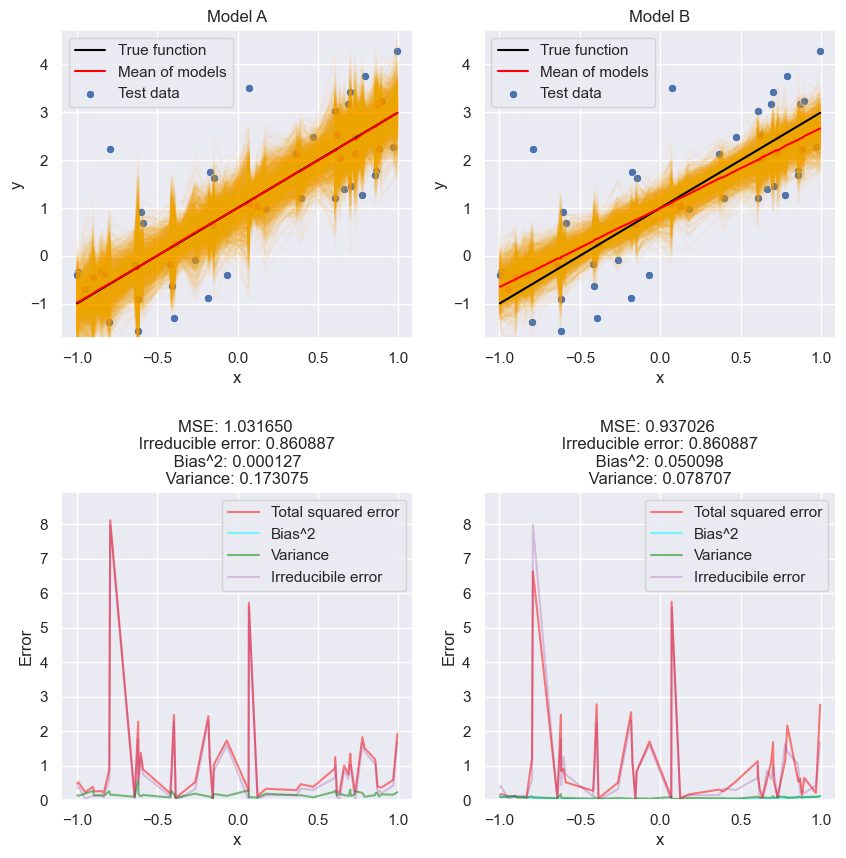

In [26]:
p = plt.figure(figsize=(10,10));

models = ['Model A', 'Model B']

for midx, model in enumerate(models):
  p = plt.subplot(2, 2, midx+1);
  for i in range(n_repeat):
    p = sns.lineplot(x=x_test[:,0], y=y_predict[:, i, midx], alpha=0.05, color='orange');
  p = sns.lineplot(x=x_test[:,0], y=y_test_no_noise, color='black', label='True function');
  p = sns.lineplot(x=x_test[:,0], y=y_predict[:, :, midx].mean(axis=1), color='red', label='Mean of models');
  p = sns.scatterplot(x=x_test[:,0], y=y_test, label='Test data');
  p = plt.xlabel('x');
  p = plt.ylabel('y');
  p = plt.title(model);
  p = plt.ylim(y_test.min()*1.1, y_test.max()*1.1)

  p = plt.subplot(2, 2, midx+3);
  p = sns.lineplot(x=x_test[:,0], y=y_test_err[:, :, midx].mean(axis=1), color='red', alpha=0.5, label='Total squared error', markers=True);
  p = sns.lineplot(x=x_test[:,0], y=y_test_bias[:, midx], color='cyan', alpha=0.5, label='Bias^2');
  p = sns.lineplot(x=x_test[:,0], y=y_predict[:, :, midx].var(axis=1), color='green', alpha=0.5, label='Variance');
  p = sns.lineplot(x=x_test[:,0], y=y_test_noise_var, color='purple', alpha=0.2, label='Irreducibile error');
  p = plt.xlabel('x');
  p = plt.ylabel('Error');
  p = plt.title("MSE: %f \n Irreducible error: %f \n Bias^2: %f \n Variance: %f " %
                (y_test_err[:,:,midx].mean(axis=(0,1)),
                 y_test_noise_var.mean(),
                 (y_test_bias[:, midx]).mean(),
                  y_predict[:, :, midx].var(axis=1).mean() ) )
  p = plt.ylim(0, 1.1* y_test_err[:, :, :].mean(axis=(1)).max() )

plt.subplots_adjust(hspace=0.5)

LASSO reduces variance, but introduces some extra bias. Because the coefficient values are pulled away from their “true” values, towards zero, the mean prediction (red line) is different from the true function (black line).

As with Ridge regression, we can use cross validation to select the value of $\alpha$ that achieves the lowest MSE (the optimal bias-variance tradeoff) on a validation data set.

### MSE contours with L1 penalty

To see why the L1 penalty “zeros” out some coefficients, we will look at the MSE contour plots of a couple of linear regressions.

In [27]:
intercept=1
coefs_a = [5,9]
coefs_b = [2, -8]

In [28]:
x_a, y_a = generate_linear_regression_data(n=1000, d=2, coef=coefs_a, intercept=intercept, sigma=2)
x_b, y_b = generate_linear_regression_data(n=1000, d=2, coef=coefs_b, intercept=intercept, sigma=2)

In [29]:
coefs = np.arange(-10, 10, 0.1)
coef_grid = np.array(np.meshgrid(coefs, coefs)).reshape(1, 2, coefs.shape[0], coefs.shape[0])

y_hat_a = (intercept + np.sum(coef_grid * x_a.reshape(x_a.shape[0], 2, 1, 1), axis=1) )
y_hat_b = (intercept + np.sum(coef_grid * x_b.reshape(x_b.shape[0], 2, 1, 1), axis=1) )

mses_a = np.mean((y_a.reshape(-1, 1, 1)- y_hat_a)**2,axis=0)
mses_b = np.mean((y_b.reshape(-1, 1, 1)- y_hat_b)**2,axis=0)
l1_penalty_coefs = np.linalg.norm(coef_grid, ord=1, axis=1).squeeze()

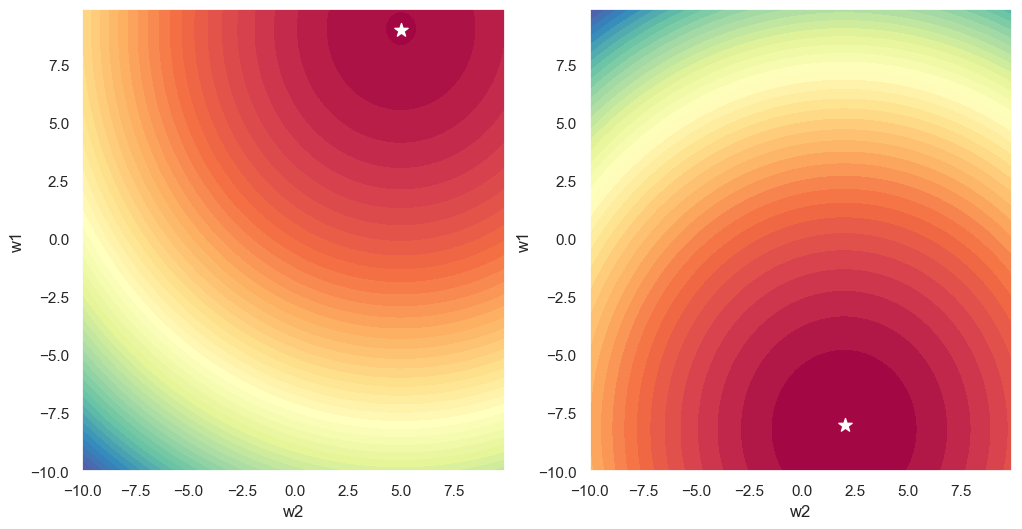

In [30]:
plt.figure(figsize=(12,6));


plt.subplot(1,2,1)
X1, X2 = np.meshgrid(coefs, coefs)
p = plt.contourf(X1, X2, mses_a, levels=50, cmap='Spectral');
plt.scatter(coefs_a[0], coefs_a[1], marker='*', color='white', s=100)
plt.xlabel('w2');
plt.ylabel('w1');

plt.subplot(1,2,2)
X1, X2 = np.meshgrid(coefs, coefs)
p = plt.contourf(X1, X2, mses_b, levels=50, cmap='Spectral');
plt.scatter(coefs_b[0], coefs_b[1], marker='*', color='white', s=100)
plt.xlabel('w2');
plt.ylabel('w1');

We can overlay the L1 penalty term on top of the MSE contours, to see the “pull” it exerts on the coefficient estimates.

The L1 penalty term pulls the coefficient estimate toward the origin, like the L2 penalty term. However, the shape of the penalty is different!

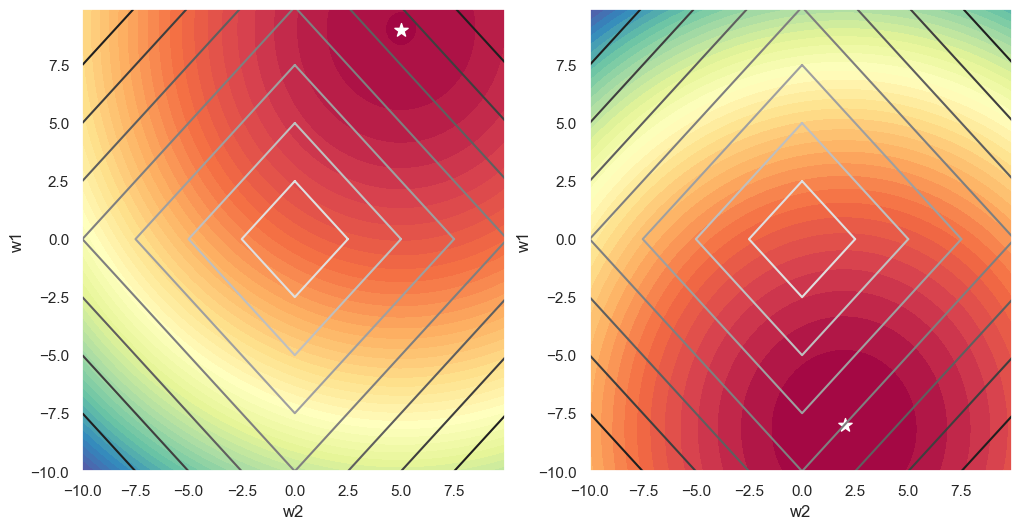

In [31]:
plt.figure(figsize=(12,6));


plt.subplot(1,2,1)
X1, X2 = np.meshgrid(coefs, coefs)
p = plt.contourf(X1, X2, mses_a, levels=50, cmap='Spectral');
p = plt.contour(X1, X2, l1_penalty_coefs, cmap='binary');
plt.scatter(coefs_a[0], coefs_a[1], marker='*', color='white', s=100)
plt.xlabel('w2');
plt.ylabel('w1');

plt.subplot(1,2,2)
X1, X2 = np.meshgrid(coefs, coefs)
p = plt.contourf(X1, X2, mses_b, levels=50, cmap='Spectral');
p = plt.contour(X1, X2, l1_penalty_coefs, cmap='binary');
plt.scatter(coefs_b[0], coefs_b[1], marker='*', color='white', s=100)
plt.xlabel('w2');
plt.ylabel('w1');

Now, we will see how the solution to the regularized loss function changes as $\alpha$ varies.

We will plot the contours of the regularized loss function along with the “path” of the optimization for different values of $\alpha$.

In [32]:
alpha_list = np.arange(0.001, 5, 0.05)
n_alphas = len(alpha_list)
coefs_lasso = np.zeros((n_alphas, 2, 2))
cost_lasso  = np.zeros((n_alphas, 2, 2))

In [33]:
for idx, alpha in enumerate(alpha_list):
  regr_lasso_a = Lasso(alpha=alpha).fit(x_a, y_a)
  coefs_lasso[idx,:,0] = regr_lasso_a.coef_
  cost_lasso[idx,:,0]  = mean_squared_error(y_a, regr_lasso_a.predict(x_a))

  regr_lasso_b = Lasso(alpha=alpha).fit(x_b, y_b)
  coefs_lasso[idx,:,1] = regr_lasso_b.coef_
  cost_lasso[idx,:,1]  = mean_squared_error(y_b, regr_lasso_b.predict(x_b))

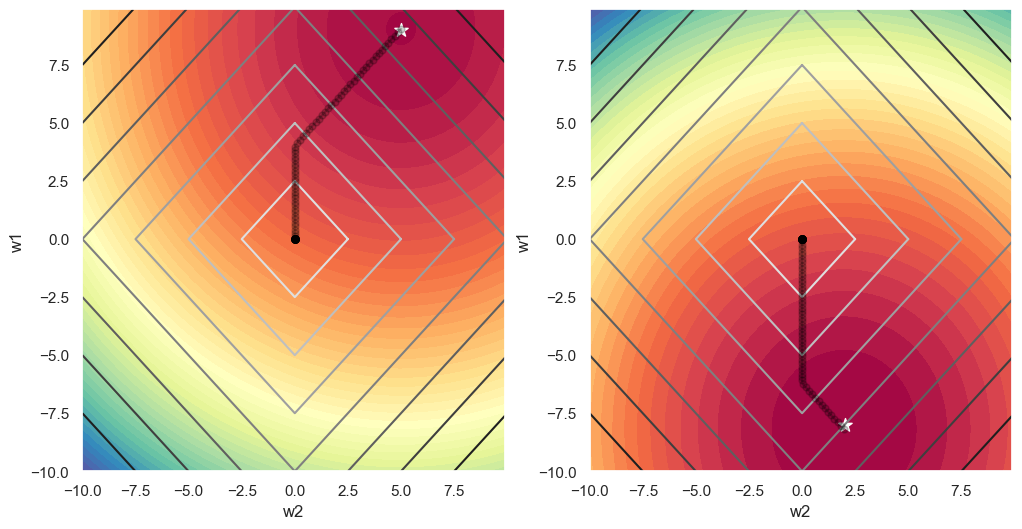

In [34]:
plt.figure(figsize=(12,6));


plt.subplot(1,2,1)
X1, X2 = np.meshgrid(coefs, coefs)
p = plt.contourf(X1, X2, mses_a, levels=50, cmap='Spectral');
p = plt.contour(X1, X2, l1_penalty_coefs, cmap='binary');
plt.plot(coefs_lasso[:,0,0], coefs_lasso[:,1,0], marker='.', color='black', markersize=10, alpha=0.2)
plt.scatter(coefs_a[0], coefs_a[1], marker='*', color='white', s=100)
plt.xlabel('w2');
plt.ylabel('w1');

plt.subplot(1,2,2)
X1, X2 = np.meshgrid(coefs, coefs)
p = plt.contourf(X1, X2, mses_b, levels=50, cmap='Spectral');
p = plt.contour(X1, X2, l1_penalty_coefs, cmap='binary');
plt.plot(coefs_lasso[:,0,1], coefs_lasso[:,1,1], marker='.', color='black', markersize=10, alpha=0.2)
plt.scatter(coefs_b[0], coefs_b[1], marker='*', color='white', s=100)
plt.xlabel('w2');
plt.ylabel('w1');

Note how LASSO shrinks the coefficients, pulling them away from the “true” coefficients and toward the origin:

-   First, LASS shrinks both coefficient estimates equally as $\alpha$ increases.
-   Eventually, one estimate - the estimate of the coefficient that has the smallest magnitude - reaches 0. From then on, as we continue to increase $\alpha$, this coefficient will remain at 0, and only the other coefficient will shrink.
-   This process continues as we increase $\alpha$ further, until all coefficients reach 0.

We can see this more clearly if we plot the regularization path on top of the LASSO loss function contour:

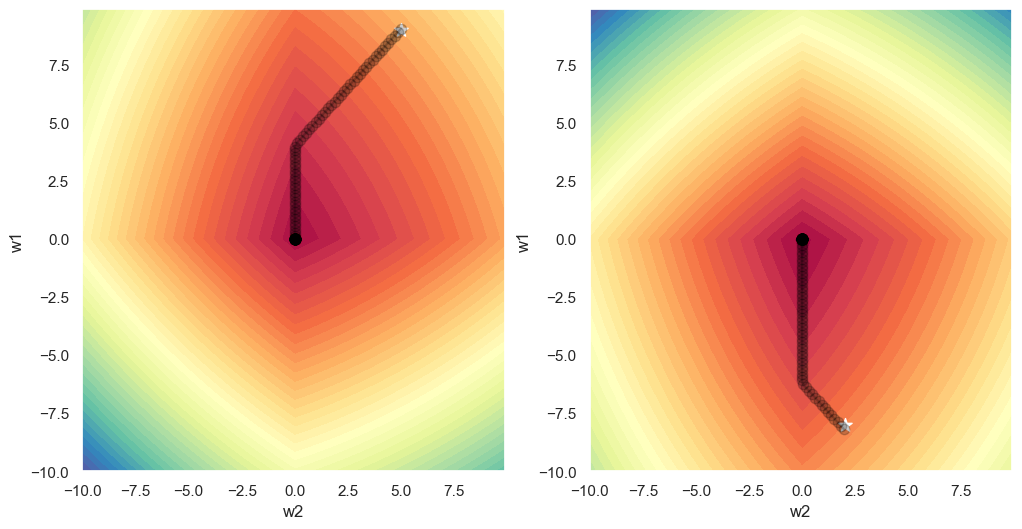

In [35]:
plt.figure(figsize=(12,6));


plt.subplot(1,2,1)
X1, X2 = np.meshgrid(coefs, coefs)
p = plt.contourf(X1, X2, mses_a + 10*l1_penalty_coefs, levels=50, cmap='Spectral');
plt.scatter(coefs_a[0], coefs_a[1], marker='*', color='white', s=100)
plt.plot(coefs_lasso[:,0,0], coefs_lasso[:,1,0], marker='.', color='black', markersize=15, alpha=0.2)
plt.xlabel('w2');
plt.ylabel('w1');

plt.subplot(1,2,2)
X1, X2 = np.meshgrid(coefs, coefs)
p = plt.contourf(X1, X2, mses_b + 10*l1_penalty_coefs, levels=50, cmap='Spectral');
plt.scatter(coefs_b[0], coefs_b[1], marker='*', color='white', s=100)
plt.plot(coefs_lasso[:,0,1], coefs_lasso[:,1,1], marker='.', color='black', markersize=15, alpha=0.2)
plt.xlabel('w2');
plt.ylabel('w1');

## 3D visualization of L1 and L2 regularization

In [36]:
coefs_true = [2,-4]
intercept = 0

coefs = np.arange(-10, 10, 0.1)
X1, X2 = np.meshgrid(coefs, coefs)
mses = np.zeros((len(coefs), len(coefs)))
penalty_coefs = np.zeros((len(coefs), len(coefs), 2))

alpha_list = np.arange(0.001, 5, 0.05)
n_alphas = len(alpha_list)

x, y = generate_linear_regression_data(n=1000, d=2,
                                coef=coefs_true, intercept=intercept, sigma=2)

for idx_1, c_1 in enumerate(coefs):
  for idx_2, c_2 in enumerate(coefs):
    y_coef = (intercept + np.dot(x,[c_1, c_2])).squeeze()
    mses[idx_1,idx_2] =  mean_squared_error(y, y_coef)
    penalty_coefs[idx_1,idx_2,0] =  np.linalg.norm( [c_1, c_2], ord=1)
    penalty_coefs[idx_1,idx_2,1] =  np.linalg.norm( [c_1, c_2], ord=2)**2

In [37]:
def plot_3D(elev=20, azim=20, a=0.001, reg='L2',
            show_cost = True, show_mse=False, show_pen=False,
            X1=X1, X2=X2, mses=mses, penalty_coefs=penalty_coefs):

    if reg=='L1':
      r_idx = 0
    if reg=='L2':
      r_idx = 1

    alpha_list = np.arange(0.001, 5.05, 0.05)
    a_idx = np.where(alpha_list>a)[0][0]

    plt.figure(figsize=(10,10))
    ax = plt.subplot(projection='3d')

    cost = mses+a*penalty_coefs[:,:,r_idx]

    if show_cost:
      ax.plot_surface(X1, X2, mses+a*penalty_coefs[:,:,r_idx], cmap='plasma',
                    linewidth=0, antialiased=False, alpha=0.4);
      # put star at minimum cost
      idx_min = np.unravel_index(cost.argmin(), cost.shape)
      ax.scatter3D(X1[idx_min], X2[idx_min], cost[idx_min]+5,
                   marker='*', color='black', s=100)

    if show_mse:
      ax.plot_surface(X1, X2, mses, alpha=0.2, cmap='gist_gray',
                          linewidth=0, antialiased=False)
    if show_pen:
      ax.plot_surface(X1, X2, a*penalty_coefs[:,:,r_idx], alpha=0.2, cmap='gist_gray',
                    linewidth=0, antialiased=False);


    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('w2')
    ax.set_ylabel('w1')
    ax.set_zlabel('Cost')
    ax.set_zlim(0, 200)
    ax.set_xlim(np.min(X2), np.max(X2))
    ax.set_ylim(np.min(X1), np.max(X1))
    plt.show()

interact(plot_3D, elev=widgets.FloatSlider(min=-90,max=90,step=1, value=20),
         azim=widgets.FloatSlider(min=-90,max=90,step=1, value=20),
         a=widgets.FloatSlider(min=0.001, max=5, step=0.05, value=0.001, description='alpha'),
         reg = widgets.RadioButtons(options=['L1', 'L2'], description='Penalty type'),
         show_cost = widgets.Checkbox(value=True, description='Show cost surface'),
         show_mse = widgets.Checkbox(value=False, description='Show MSE surface'),
         show_pen = widgets.Checkbox(value=False, description='Show regularization penalty surface'),
         X1=fixed(X1), X2=fixed(X2),
         mses=fixed(mses), penalty_coefs=fixed(penalty_coefs));


interactive(children=(FloatSlider(value=20.0, description='elev', max=90.0, min=-90.0, step=1.0), FloatSlider(…